In [11]:
import numpy as np 
import matplotlib.pyplot as plt
import tenpy

from tenpy.networks.site import SpinHalfSite
from tenpy.models.lattice import Site, Chain

import numpy as np

from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.models.spins import SpinModel
from tenpy.algorithms import dmrg, exact_diag
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel, CouplingMPOModel
from tenpy.networks.site import SpinHalfSite

import cirq
from numpy import linalg as LA

from typing import *

from entanglement_tools import *

# Computing DMRG results

Here, we'll compute quantities throughout spin chains including 
 - Von Neumann Entanglement Entropy
 - 2nd Renyi entropy
 - correlation functions
 - local expectations

In [12]:
class TFIModel2(CouplingMPOModel):
    r"""Transverse field Ising model on a general lattice.
    The Hamiltonian reads:
    .. math ::
        H = - \sum_{\langle i,j\rangle, i < j} \mathtt{J} \sigma^z_i \sigma^z_{j}
            - \sum_{i} \mathtt{g} \sigma^x_i
    Here, :math:`\langle i,j \rangle, i< j` denotes nearest neighbor pairs, each pair appearing
    exactly once.
    All parameters are collected in a single dictionary `model_params`, which
    is turned into a :class:`~tenpy.tools.params.Config` object.
    Parameters
    ----------
    model_params : :class:`~tenpy.tools.params.Config`
        Parameters for the model. See :cfg:config:`TFIModel` below.
    Options
    -------
    .. cfg:config :: TFIModel
        :include: CouplingMPOModel
        conserve : None | 'parity'
            What should be conserved. See :class:`~tenpy.networks.Site.SpinHalfSite`.
        J, g : float | array
            Coupling as defined for the Hamiltonian above.
    """
    def init_sites(self, model_params):
        conserve = model_params.get('conserve', 'parity')
        assert conserve != 'Sz'
        if conserve == 'best':
            conserve = 'parity'
            self.logger.info("%s: set conserve to %s", self.name, conserve)
        site = SpinHalfSite(conserve=conserve)
        return site

    def init_terms(self, model_params):
        J = np.asarray(model_params.get('J', 1.))
        g = np.asarray(model_params.get('g', 1.))
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(g, u, 'Sigmax')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(J, u1, 'Sigmaz', u2, 'Sigmaz', dx)
        # done

In [13]:
def DMRG_obtain_gs(model, run_ed = False):
    
    product_state = ["up"] * model.lat.N_sites
    psi = MPS.from_product_state(model.lat.mps_sites(), product_state, bc=model.lat.bc_MPS)
    dmrg_params = {
        'mixer': None,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 30,
            'svd_min': 1.e-10
        },
        'combine': True
    }
    
    """
    Below we run DMRG
    """
    info = dmrg.run(psi, model, dmrg_params)
    E = info['E']
    
    """
    Now we run exact diagonalization
    """
    if run_ed:
        ED = exact_diag.ExactDiag(model)
        ED.build_full_H_from_mpo()
        # ED.build_full_H_from_bonds()  
        ED.full_diagonalization()  # the expensive part for large L
        E0_ED, psi_ED = ED.groundstate()

        return E, psi, M, E0_ED, psi_ED
    
    return E, psi, M

Now we use a function to check the DMRG diagonalization
This is taken from a tenpy example

In [14]:
model_params = dict(L=10, J=-1., g=-1, bc_MPS='finite', conserve=None)

M = TFIModel2(model_params)

E, psi, M, E0_ED, psi_ED = DMRG_obtain_gs(M, run_ed = True)

print(E)
print(E0_ED)

-12.381489999654782
-12.381489999654754


# Computing for the current model

if length=10, we'll treat this as a test case, and compare results to the ED answer

In [16]:
length=80

model_params = dict(L=length, J=-1., g=-1, bc_MPS='finite', conserve=None)

M = TFIModel2(model_params)

E, psi, M = DMRG_obtain_gs(M, run_ed = False)

In [ ]:
print(E)

In [ ]:
if length==10:
    tfim_ham = cirq.PauliSum()

    for i in range(9):
        tfim_ham -= cirq.Z(cirq.LineQubit(i))*cirq.Z(cirq.LineQubit(i+1))

    for i in range(10):
        tfim_ham -= cirq.X(cirq.LineQubit(i))
    
    ham_mat = tfim_ham.matrix()
    ws, vs =LA.eigh(ham_mat)

    gs = vs[:, 0]
    
    
    x_operators = [
        cirq.X(cirq.LineQubit(i)).matrix(cirq.LineQubit.range(10))
        for i in range(10)
    ]
    z_operators = [
        cirq.Z(cirq.LineQubit(i)).matrix(cirq.LineQubit.range(10))
        for i in range(10)
    ]

In [8]:
tfim_ham = cirq.PauliSum()

for i in range(9):
    tfim_ham -= cirq.Z(cirq.LineQubit(i))*cirq.Z(cirq.LineQubit(i+1))

for i in range(10):
    tfim_ham -= cirq.X(cirq.LineQubit(i))

ham_mat = tfim_ham.matrix()
ws, vs =LA.eigh(ham_mat)

gs = vs[:, 0]


x_operators = [
    cirq.X(cirq.LineQubit(i)).matrix(cirq.LineQubit.range(10))
    for i in range(10)
]
z_operators = [
    cirq.Z(cirq.LineQubit(i)).matrix(cirq.LineQubit.range(10))
    for i in range(10)
]

In [9]:
gs @ z_operators[0] @ gs

(1.6167622796103842e-15+0j)

## Correlation Functions

First we compute correlation functions in x and z

In [17]:
xx_correlators = psi.correlation_function("Sx", "Sx")*4
zz_correlators = psi.correlation_function("Sz", "Sz")*4

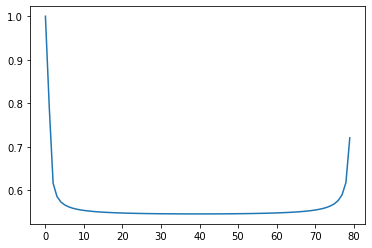

In [26]:
plt.plot(xx_correlators[0, :])

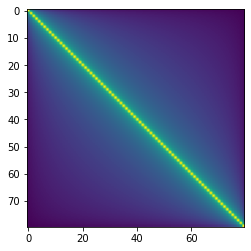

In [20]:
plt.imshow(zz_correlators)

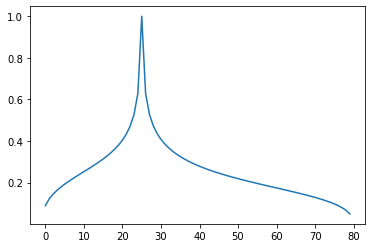

In [22]:
plt.plot(zz_correlators[25, :])

In [9]:
if length==10:
    ed_xx_correlators = np.array(
        [[gs @ (x_operators[i]@x_operators[j]) @ gs for i in range(10)] for j in range(10)],
        dtype=np.float64
    )
    ed_zz_correlators = np.array(
        [[gs @ (z_operators[i]@z_operators[j]) @ gs for i in range(10)] for j in range(10)],
        dtype=np.float64
    )
    
    print(np.max(np.abs(ed_xx_correlators - xx_correlators)))
    print(np.max(np.abs(ed_zz_correlators - zz_correlators)))
    
    plt.imshow(xx_correlators, interpolation='nearest')
    plt.show()
    plt.imshow(ed_xx_correlators, interpolation='nearest')
    plt.show()
    
    plt.imshow(zz_correlators, interpolation='nearest')
    plt.show()
    plt.imshow(ed_zz_correlators, interpolation='nearest')
    plt.show()

## Expectations

Now compute x and z local expectations

In [27]:

x_expectations = psi.expectation_value(ops='Sx')*2

z_expectations = psi.expectation_value(ops='Sz')*2


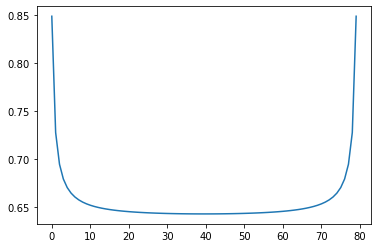

In [30]:
plt.plot(x_expectations)

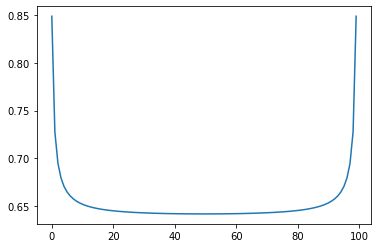

In [29]:
plt.plot(x_expectations)

In [11]:
if length==10:
    ed_x_expectations = np.array([np.real(gs @ x_operators[i] @ gs) for i in range(10)])
    ed_z_expectations = np.array([np.real(gs @ z_operators[i] @ gs) for i in range(10)])
    
    plt.plot(ed_x_expectations)
    plt.plot(x_expectations, linestyle='dashed')
    plt.show()
    
    plt.plot(ed_z_expectations)
    plt.plot(z_expectations, linestyle='dashed')
    plt.show()

## Entanglement

compute the Von Neumann and second Renyi entropies

here, we'll collect a dictionary of all values

In [12]:
s1_dict = {}

for i in range(length):
    for j in range(i+1, length+1):
        #print(i, j, list(range(i, j)))
        s1_val = psi.entanglement_entropy_segment2(range(i, j), n=1)
        
        s1_dict[(i, j)] = s1_val
        
        if length == 10:
            
            if j!=10:
                ed_s1 = give_entanglement_entropy(
                    state=gs,
                    region=(i, j),
                )

                assert abs(ed_s1-s1_val)/ed_s1 <10**-6

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: inefficient: use `entanglement_entropy_segment` instead!
  


In [13]:
s2_dict = {}

for i in range(length):
    for j in range(i+1, length+1):
        #print(i, j, list(range(i, j)))
        s2_val = psi.entanglement_entropy_segment2(range(i, j), n=2)
        
        s2_dict[(i, j)] = s2_val
        
        if length == 10:
            
            if j!=10:
                trace = give_nth_renyi(
                    n=2,
                    state=gs,
                    region=(i, j),
                )

                assert abs(-np.log(trace)-s2_val)/(-np.log(trace)) <10**-6

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: inefficient: use `entanglement_entropy_segment` instead!
  


## Saving data

In [15]:
import json

In [24]:
name = f"DMRG_TFIM_length_{length}_data"

np.save(f"xx_correlators_{name}", xx_correlators)
np.save(f"zz_correlators_{name}", zz_correlators)

np.save(f"x_expectations_{name}", x_expectations)
np.save(f"z_expectations_{name}", z_expectations)

with open(f"s1_dict_{name}.json", "w") as outfile:
    json.dump(mod_s1_dict, outfile)

with open(f"s2_dict_{name}.json", "w") as outfile:
    json.dump(mod_s2_dict, outfile)

In [17]:
s1_dict

{(0, 1): 0.26782380135065814,
 (0, 2): 0.33717195363696006,
 (0, 3): 0.37599507584832104,
 (0, 4): 0.4026842524946171,
 (0, 5): 0.4229254479906472,
 (0, 6): 0.4391796169288948,
 (0, 7): 0.45272637859066317,
 (0, 8): 0.4643136122445192,
 (0, 9): 0.4744154296661854,
 (0, 10): 0.4833509263522846,
 (0, 11): 0.49134495675076123,
 (0, 12): 0.4985618305506225,
 (0, 13): 0.5051252050466613,
 (0, 14): 0.5111304374155152,
 (0, 15): 0.5166525810264072,
 (0, 16): 0.5217517457443116,
 (0, 17): 0.5264767994544325,
 (0, 18): 0.5308679902985562,
 (0, 19): 0.5349588460936548,
 (0, 20): 0.5387775773002268,
 (0, 21): 0.5423481313510825,
 (0, 22): 0.5456909972612742,
 (0, 23): 0.5488238281868904,
 (0, 24): 0.5517619291388572,
 (0, 25): 0.5545186433703541,
 (0, 26): 0.557105661622436,
 (0, 27): 0.5595332719339524,
 (0, 28): 0.5618105631527356,
 (0, 29): 0.5639455920106342,
 (0, 30): 0.5659455212487915,
 (0, 31): 0.5678167345455042,
 (0, 32): 0.5695649327271188,
 (0, 33): 0.5711952146630964,
 (0, 34): 0.572

In [21]:
mod_s1_dict = dict()
for key in s1_dict:
    mod_s1_dict[str(key)] = s1_dict[key]

mod_s2_dict = dict()
for key in s2_dict:
    mod_s2_dict[str(key)] = s2_dict[key]

In [30]:
np.save(f"x_expectations_{name}", x_expectations)
np.save(f"z_expectations_{name}", z_expectations)

In [19]:
sff = str(ff)

In [20]:
tuple(sff)

('(', '1', ',', ' ', '2', ')')

In [25]:
name

'DMRG_TFIM_length_100_data'